# Gamma Hedging

## Motivation of Gamma Hedging:
As we have seen, in practice delta hedging alone cannot explain market prices: it is cheaper to buy exchange traded options than to delta hedge.  
If we could ensure that our portfolio had a delta of zero and a gamma of zero, we could ensure that it won't change to second order in the stock price.  
Where hedging comes in is that it means that the trader doesn't need to precisely match there buying and selling activity. At the end of the days trading, the trader will be left with some net risky position.  
Notice that the trader does not need to hedge each trade they have performed individually. They can rehedge an entire portfolio with just a couple of trades.

## Framework
In detail, the gamma hedging strategy is to write a portfolio of options and then at fixed time intervals, purchase stock and an exchange traded option so that our portfolio consisting of:

- our stock holding   
- our holding in exchange traded options  
- our liability (the exotic option)  
- our bank balance  

has an aggregate delta of zero and an aggregate gamma of zero.

For simplicity, let us suppose that the hedged portfolio consists of a single option.  
Here, a stock follow a GBM with parameters: r = 0.05, vol = 0.02. Initial stock price is 100€.  

## Gamma Hedging strategie and Cash FLlow:
**At time j:**
Stock price is $S_j$.  
The option we are writing has strike $K_1$, BS price $P^1_j$, delta $\Delta^1_j$ and gamma $\Gamma^1_j$.  
The hedging option has price $P^2_j$, delta $\Delta^2_j$ and gamma $\Gamma^2_j$.  
Trader's bank balance is $b_j$, trader's stock holding is $q^S_j$, trader's holding in option 1 is $q^1_j=-1$ and trader's holding in option 2 is $q^2_j$. Then, by linearity, the delta of the portfolio is $q^S_j + \Delta^1_j q^1_j + \Delta^2_j q^2_j$.  
Gamma of the portfolio is: $ \Gamma^1_j q^1_j + \Gamma^2_j q^2_j$.  

We are seeking a **delta-neutral portfolio**, then: 
$$
\begin{aligned} q^S_j - \Delta^1_j + \Delta^2_j q^2_j &= 0 \\
\Gamma^1_j + \Gamma^2_j q^2_j &= 0 
\end{aligned}
$$
We deduce that:
$$
\begin{aligned} q^2_j &= \frac{\Gamma^1_j}{\Gamma^2_j} \\ 
q^S_j &= \Delta^1_j + \Delta^2_j q^2_j 
\end{aligned}
$$
These recurrence relations allow us to simulate the strategy. Potential issue: When $\Gamma^2_j$ becomes very small.  
Note that we have solved two linear equations to get a gamma neutral portfolio. This is why we need to trade in two products (the stock and the hedging option) in order to obtain a gamma neutral portfolio.

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# input BS
asset_price = 100
asset_volatility = 0.2
time_to_expiration = 1.0
risk_free_rate = 0.05


strike_price_1 = 110
strike_price_2 = 90

NbSteps = 365
NbPaths = 1000

In [3]:
class BlackScHolesClass:
    def __init__(self, asset_price, asset_volatility, strike_price_1, strike_price_2, time_to_expiration, risk_free_rate):
        self.asset_price = asset_price
        self.asset_volatility = asset_volatility
        self.time_to_expiration = time_to_expiration
        self.risk_free_rate = risk_free_rate
        
        self.strike_price_1 = strike_price_1
        self.strike_price_2 = strike_price_2
        
        self.NbSteps = 500
        self.NbPaths = 1000
        
        self.BSpaths = self.generateBSpaths()
        self.BSpath = self.generateOneBSPath()
        
        self.price_1 = self.call_price(asset_price, asset_volatility, strike_price_1, time_to_expiration, risk_free_rate)
        self.delta_1 = self.call_delta(asset_price, asset_volatility, strike_price_1, time_to_expiration, risk_free_rate)
        self.gamma_1 = self.call_gamma(asset_price, asset_volatility, strike_price_1, time_to_expiration, risk_free_rate)

        self.price_2 = self.call_price(asset_price, asset_volatility, strike_price_2, time_to_expiration, risk_free_rate)
        self.delta_2 = self.call_delta(asset_price, asset_volatility, strike_price_2, time_to_expiration, risk_free_rate)
        self.gamma_2 = self.call_gamma(asset_price, asset_volatility, strike_price_2, time_to_expiration, risk_free_rate)
        
    def generateBSpaths(self):
        self.dt = self.time_to_expiration / self.NbSteps
        log_ST = np.log(self.asset_price) +  np.cumsum(((self.risk_free_rate - self.asset_volatility ** 2 / 2.0) * self.dt +\
                              self.asset_volatility * np.sqrt(self.dt) * \
                              np.random.normal(size=(self.NbSteps, self.NbPaths))),axis=0)
        return np.exp(log_ST)
    
    def generateOneBSPath(self):
        self.dt = self.time_to_expiration / self.NbSteps
        log_ST = np.log(self.asset_price) +  np.cumsum(((self.risk_free_rate - self.asset_volatility ** 2 / 2.0) * self.dt +\
                              self.asset_volatility * np.sqrt(self.dt) * \
                              np.random.normal(size = self.NbSteps)),axis=0)
        return np.exp(log_ST)
    
    def plot_BSPaths(self):
        plt.plot(self.BSpaths)
        plt.xlabel("Time Increments")
        plt.ylabel("Stock Price")
        plt.title("Geometric Brownian Motion")
        
    def call_payoff(self, asset_price_t, strike_price):
        return np.maximum(asset_price_t - strike_price, 0.0)

    def call_price(
            self, asset_price, asset_volatility, strike_price,
            time_to_expiration, risk_free_rate
    ):
        b = math.exp(-risk_free_rate * time_to_expiration)
        x1 = math.log(asset_price / (b * strike_price)) + .5 * (
                    asset_volatility * asset_volatility) * time_to_expiration
        x1 = x1 / (asset_volatility * (time_to_expiration ** .5))
        z1 = norm.cdf(x1)
        z1 = z1 * asset_price
        x2 = math.log(asset_price / (b * strike_price)) - .5 * (
                    asset_volatility * asset_volatility) * time_to_expiration
        x2 = x2 / (asset_volatility * (time_to_expiration ** .5))
        z2 = norm.cdf(x2)
        z2 = b * strike_price * z2
        return z1 - z2

    def call_delta(
            self, asset_price, asset_volatility, strike_price,
            time_to_expiration, risk_free_rate ):
        b = math.exp(-risk_free_rate * time_to_expiration)
        x1 = math.log(asset_price / (b * strike_price)) + .5 * (
                    asset_volatility * asset_volatility) * time_to_expiration
        x1 = x1 / (asset_volatility * (time_to_expiration ** .5))
        z1 = norm.cdf(x1)
        return z1

    def call_gamma(
            self, asset_price, asset_volatility, strike_price,
            time_to_expiration, risk_free_rate
    ):
        b = math.exp(-risk_free_rate * time_to_expiration)
        x1 = math.log(asset_price / (b * strike_price)) + .5 * (
                    asset_volatility * asset_volatility) * time_to_expiration
        x1 = x1 / (asset_volatility * (time_to_expiration ** .5))
        z1 = norm.cdf(x1)
        z2 = z1 / (asset_price * asset_volatility * math.sqrt(time_to_expiration))
        return z2

    def call_vega(
            self, asset_price, asset_volatility, strike_price,
            time_to_expiration, risk_free_rate
    ):
        b = math.exp(-risk_free_rate * time_to_expiration)
        x1 = math.log(asset_price / (b * strike_price)) + .5 * (
                    asset_volatility * asset_volatility) * time_to_expiration
        x1 = x1 / (asset_volatility * (time_to_expiration ** .5))
        z1 = norm.cdf(x1)
        z2 = asset_price * z1 * math.sqrt(time_to_expiration)
        return z2 / 100
    
    def GetGammaHedging(self):
        dt = self.time_to_expiration / self.NbSteps
        self.df = np.exp(self.risk_free_rate * dt)
        times_horizon = np.linspace(0.0, self.time_to_expiration, num=self.NbSteps+1)

        option_1_quantity = -1
        option_2_quantity = max(min(self.gamma_1/self.gamma_2, 100.0),-100.0)
        stock_quantity = self.delta_1 - option_2_quantity * self.delta_2 
        
        Initial_stock_cost = stock_quantity * self.asset_price
        Initial_option2_cost = option_2_quantity * self.price_2
        
        charge_to_customer = self.price_1
        BankBalance = charge_to_customer - Initial_stock_cost - Initial_option2_cost 
        
        for t in range(self.NbSteps - 1):
            S_t = self.BSpath[t]
            TimeToMaturity = self.time_to_expiration - times_horizon[t]
            
            price_1 = self.call_price(S_t, asset_volatility, strike_price_1, TimeToMaturity, risk_free_rate)
            delta_1 = self.call_delta(S_t, asset_volatility, strike_price_1, TimeToMaturity, risk_free_rate)
            gamma_1 = self.call_gamma(S_t, asset_volatility, strike_price_1, TimeToMaturity, risk_free_rate)

            price_2 = self.call_price(S_t, asset_volatility, strike_price_2, TimeToMaturity, risk_free_rate)
            delta_2 = self.call_delta(S_t, asset_volatility, strike_price_2, TimeToMaturity, risk_free_rate)
            gamma_2 = self.call_gamma(S_t, asset_volatility, strike_price_2, TimeToMaturity, risk_free_rate)
        
            NewOption2Quantity = max(min(gamma_1/gamma_2, 100.0),-100.0)
            NewStockQuantity = delta_1 - NewOption2Quantity * delta_2
            
            StockCost = (NewStockQuantity - stock_quantity) * S_t
            Option2Cost = (NewOption2Quantity - option_2_quantity) * price_2
            BankBalance =  self.df * BankBalance - StockCost - Option2Cost
            
            stock_quantity = NewStockQuantity
            option_2_quantity = NewOption2Quantity
            
            market_value = BankBalance + stock_quantity * S_t + option_1_quantity * price_1 + option_2_quantity * price_2 
        return market_value
  

    def MultipleGammaHedging(self, simulation_test = 50, Plot=True):
        dt = self.time_to_expiration / self.NbSteps
        self.df = np.exp(self.risk_free_rate * dt)
        times_horizon = np.linspace(0.0, self.time_to_expiration, num=self.NbSteps+1)
        MarketValue_all = np.empty(0)
        for i in range(simulation_test):
            BSpath_i = self.BSpaths[:, i]
            option_1_quantity = -1
            option_2_quantity = max(min(self.gamma_1/self.gamma_2, 100.0),-100.0)
            stock_quantity = self.delta_1 - option_2_quantity * self.delta_2 

            Initial_stock_cost = stock_quantity * self.asset_price
            Initial_option2_cost = option_2_quantity * self.price_2

            charge_to_customer = self.price_1
            BankBalance = charge_to_customer - Initial_stock_cost - Initial_option2_cost 
            market_value = None
            for t in range(self.NbSteps - 1):
                S_t = BSpath_i[t]
                TimeToMaturity = self.time_to_expiration - times_horizon[t]

                price_1 = self.call_price(S_t, asset_volatility, strike_price_1, TimeToMaturity, risk_free_rate)
                delta_1 = self.call_delta(S_t, asset_volatility, strike_price_1, TimeToMaturity, risk_free_rate)
                gamma_1 = self.call_gamma(S_t, asset_volatility, strike_price_1, TimeToMaturity, risk_free_rate)

                price_2 = self.call_price(S_t, asset_volatility, strike_price_2, TimeToMaturity, risk_free_rate)
                delta_2 = self.call_delta(S_t, asset_volatility, strike_price_2, TimeToMaturity, risk_free_rate)
                gamma_2 = self.call_gamma(S_t, asset_volatility, strike_price_2, TimeToMaturity, risk_free_rate)

                NewOption2Quantity = max(min(gamma_1/gamma_2, 100.0),-100.0)
                NewStockQuantity = delta_1 - NewOption2Quantity * delta_2

                StockCost = (NewStockQuantity - stock_quantity) * S_t
                Option2Cost = (NewOption2Quantity - option_2_quantity) * price_2
                BankBalance =  self.df * BankBalance - StockCost - Option2Cost

                stock_quantity = NewStockQuantity
                option_2_quantity = NewOption2Quantity

                market_value = BankBalance + stock_quantity * S_t + option_1_quantity * price_1 + option_2_quantity * price_2 
            MarketValue_all = np.insert(MarketValue_all, 0, market_value)
            
        if Plot:
            plt.hist(MarketValue_all)
            plt.title("Distribution of profits when delta-gamma hedging daily and charging BS Price")
            plt.show()
    
        return MarketValue_all

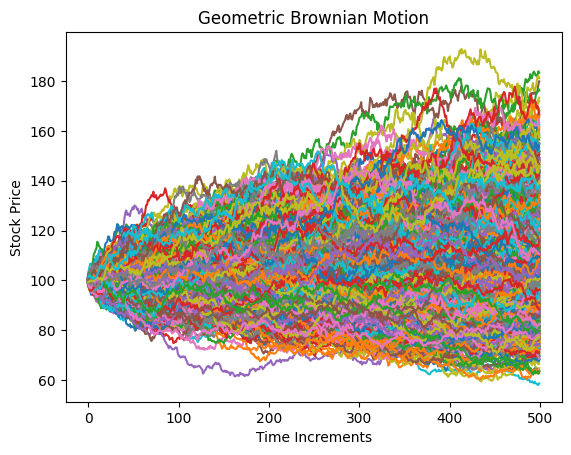

In [4]:
BlackScHolesObject = BlackScHolesClass(asset_price, asset_volatility, strike_price_1, strike_price_2, time_to_expiration, risk_free_rate)
paths = BlackScHolesObject.generateBSpaths()
BlackScHolesObject.plot_BSPaths()

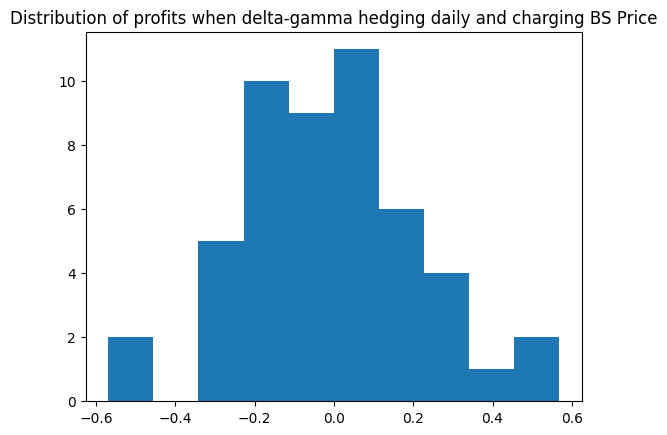

In [5]:
gamma_hedging = BlackScHolesObject.GetGammaHedging()
Multplit_gamma_hedging = BlackScHolesObject.MultipleGammaHedging()